# RNN for japanese character classification

In [1]:
import time
import math

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from utils import load_data, file_to_tensor, character_to_tensor, random_training_example

## Netzarchitektur

In [2]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset
character_files, all_characters = load_data(subfolder="train")

# hyper parameters
n_features = 3 # input_size -> x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128

learning_rate = 0.001

# Netzarchitektur
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        # input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # input to output
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        # Kombinieren entlang der ersten Dimension
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        # Initialisierung hidden-state
        return torch.zeros(1, self.hidden_size)


def train(file_tensor, character_tensor):
    hidden = rnn.init_hidden()
    
    # über seq-lenght iterieren
    for i in range(file_tensor.size()[0]):
        output, hidden = rnn(file_tensor[i], hidden)
        
    loss = criterion(output, character_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()


def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Training loop

In [3]:
rnn = RNN(n_features, hidden_size, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

plot_steps, print_steps = 100, 500
n_iters = 10000

print_every = 500
plot_every = 100
n_iters = 10000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # Add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (0m 55s) 1.5552 data/train\e__49604.csv / u ✗ (e)
1000 10% (1m 46s) 1.5610 data/train\u__15626.csv / e ✗ (u)
1500 15% (2m 39s) 1.6376 data/train\i__02369.csv / e ✗ (i)
2000 20% (3m 31s) 1.4448 data/train\u__94863.csv / u ✓
2500 25% (4m 23s) 1.4455 data/train\u__94863.csv / o ✗ (u)
3000 30% (5m 15s) 1.5412 data/train\i__02369.csv / i ✓
3500 35% (5m 56s) 1.0463 data/train\u__27434.csv / o ✗ (u)
4000 40% (6m 35s) 0.0229 data/train\e__00867.csv / e ✓
4500 45% (7m 18s) 0.0220 data/train\e__11863.csv / e ✓
5000 50% (8m 13s) 1.3361 data/train\a__77402.csv / a ✓
5500 55% (9m 5s) 1.6480 data/train\e__54428.csv / a ✗ (e)
6000 60% (9m 58s) 1.5597 data/train\e__54428.csv / a ✗ (e)
6500 65% (10m 42s) 1.3107 data/train\o__10867.csv / u ✗ (o)
7000 70% (11m 30s) 1.2773 data/train\o__42940.csv / u ✗ (o)
7500 75% (12m 6s) 1.2769 data/train\o__42151.csv / u ✗ (o)
8000 80% (12m 44s) 1.9247 data/train\a__36857.csv / o ✗ (a)
8500 85% (13m 28s) 1.2907 data/train\o__07804.csv / u ✗ (o)
9000 90% (14m 5s

## Plot der LOSS-Funktion

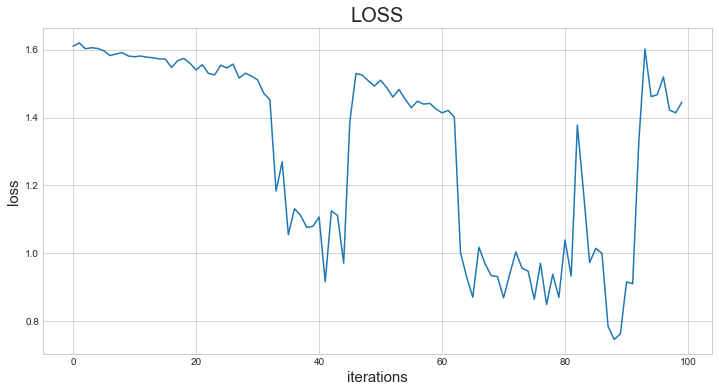

In [4]:
# Erstellung der Figure zur Ausgabe vom Loss
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# Erzeugung des Plots
plt.plot(all_losses)
# Bezeichnungen
plt.title("LOSS", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# Plot anzeigen
plt.show()

## Speichern des Models

In [5]:
FILE = "main.pth"
torch.save(rnn.state_dict(), FILE)

## Laden des Models

In [ ]:
loaded_model = RNN(n_features, hidden_size, n_characters)
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()

## Accuracy bestimmmen

In [11]:
# load dataset
character_files, all_characters = load_data(subfolder="test")

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    # alle Testdaten auswerten
    for character in all_characters:
        # alle Testdateien eines Characters
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            hidden = rnn.init_hidden()
            # über seq_lenght iterieren um letzen output zu bekommen
            for i in range(file_tensor.size()[0]):
                output, hidden = rnn(file_tensor[i], hidden)
            
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
    
    acc = 100.0 * n_correct / n_samples # Genauigkeit in % 
    print(f"accuracy = {acc:.2f} %")

accuracy = 46.15 %
